In [1]:
import pandas as pd

In [2]:
#!/usr/bin/python
import collections
import csv
import datetime
import ipaddr
import sys


_FLOW_FIELDS = [
    "ts",
    "ip_protocol",
    "state",
    "src_ip",
    "src_port",
    "dst_ip",
    "dst_port",
    "src_tx",
    "dst_tx",
]


class Flow(collections.namedtuple("Flow", _FLOW_FIELDS)):
    __slots__ = ()

    @staticmethod
    def from_csv(e):
        """
        Factory method.

        Construct Flow instances from a CSV-representation of a flow.
        """
        return Flow(ts=datetime.datetime.strptime(e[0], "%Y-%m-%d %H:%M:%S"),
                    ip_protocol=e[1],
                    state=e[2],
                    src_ip=ipaddr.IPAddress(e[3]),
                    src_port=int(e[4]),
                    dst_ip=ipaddr.IPAddress(e[5]),
                    dst_port=int(e[6]),
                    src_tx=int(e[7]),
                    dst_tx=int(e[8]))

_ALERT_FIELDS = [
    "name",
    "evidence",
]

Alert = collections.namedtuple("Alert", _ALERT_FIELDS)


class Analyzer(object):

    def __init__(self):
        self.__num_flows = 0

        self.__alerts = []
        
        self.flow_list = []
        self.__T = 10
        self.__refresh_ports_cycle = 60     # cycles to refresh dst_ports
        self.__refresh_ports_counter = 0
        
    def alert_flow_statistics(self):
        self.__refresh_ports_counter += 1   # increase counter on entering this function
        
        get_attributes_from_flow_list(self.flow_list)

        if self.__refresh_ports_counter == self.__refresh_ports_cycle:
            self.__flush_dst_port_dict()
            self.__refresh_ports_counter = 0
        pass
    
    def __flush_dst_port_dict(self):
        pass

    def process(self, flow):
        """
        Process a flow.

        :param Flow flow: a data flow record
        """
        self.__num_flows += 1

        self.flow_list.append(flow)
        if int(flow.ts.strftime('%s')) % self.__T == 0:
            self.alert_flow_statistics()
            self.flow_list = []

    @property
    def alerts(self):
        """
        Return the alerts that were generated during the processing of flows.

        :return: a list of alerts
        :rtype: List[Alert]
        """
        return self.__alerts


def main(argv):
    analyzer = Analyzer()

    fin = csv.reader(sys.stdin)
    for e in fin:
        flow = Flow.from_csv(e)
        analyzer.process(flow)

    for alert in analyzer.alerts:
        print(alert.name)
        print("\n".join("\t{}".format(e) for e in alert.evidence))

    return 0


if __name__ == "__main__":
    sys.exit(main(sys.argv))

SystemExit: 0

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [24]:
analyzer = Analyzer()

with open("data.csv", "r") as csvfile:
    # pass input data stream as open("data.csv", "r") to csv.reader for testing
    # read and process line by line don't read into list
    fin = csv.reader(csvfile)
    for e in fin:
        flow = Flow.from_csv(e)
        analyzer.process(flow)

    for alert in analyzer.alerts:
        print(alert.name)
        print("\n".join("\t{}".format(e) for e in alert.evidence))

### Alert Flow Statistics


    Aggregate flow counters every T=10 seconds.
    Input: self (list of flows collected for last T seconds)
    Use pandas DataFrame for quick calculations

    TODO: move (srcip, dstip) to a new IPPairStats class
    Take (srcip, dstip) key and find distribution of packets, bytes
    dst_ports_used by (src_ip, dst_ip) as dict with time_last_used
        - used to create count of ports
        - dict can be refreshed every 10 mins or so to remove old entries (so after 600/T cycles)
    int: number of new dst_ports: calculated from additions to above list
    int: percentile X new dst_ports across all pairs
    int: number of current dst_ports: len (dst_ports_used for (src_ip, dst_ip) pair)
    int: percentile X current dst_ports across all pairs
    int: number of flow_tuples not closed yet (num_new - num_closed)
    int: bytes_up, bytes_dw in T sec
    int: percentile X bytes_up, bytes_dw in T s across all pairs
    int: number of packets/entries in T sec
    int: percentile X packets in T s across all pairs

    methods:
    - percentileX of distribution (list)
    - refresh open dst_port dict every 60 cycles (for 10 mins)

    Simple threshold based algo:
    if ( bytes(src,dst) > percentileX_bytes ) & (numPackets() > percentileX_packets )
    & (num_new_dst_ports > percentileX_new_dst_ports) & (num_dst_ports > percentileX_dst_ports)


In [3]:
FLOW_LIST = []

def get_attributes_from_flow_list(flow_list):
    df = pd.DataFrame(flow_list)
    return 

In [4]:
#analyzer = Analyzer()
DATA = []
FLOW_LIST = []
T = 10

with open("data.csv", "r") as csvfile:
    # pass input data stream as open("data.csv", "r") to csv.reader for testing
    # read and process line by line don't read into list
    fin = csv.reader(csvfile)
    for e in fin:
        flow = Flow.from_csv(e)
        FLOW_LIST.append(flow)
        if int(flow.ts.strftime('%s')) % 10 == 0:
            DATA.append(FLOW_LIST)
            FLOW_LIST = []

# Analyze T=10s Flow Lists

- Randomly take a large flow list as starting point

In [5]:
len(DATA)

12904

In [6]:
for flow_list in DATA:
    if len(flow_list)>100:
        df = pd.DataFrame(flow_list)
        break

In [7]:
df.head()

df['src_ip'] = df['src_ip'].apply(str)
df['dst_ip'] = df['dst_ip'].apply(str)

In [8]:
gp = df.groupby(['src_ip', 'dst_ip'])

In [9]:
df2 = gp['src_tx', 'dst_tx'].sum()

In [10]:
df2['num_conns'] = gp['state'].count()

In [11]:
df2['num_dst_ports'] = gp['dst_port'].unique().apply(lambda x: len(x))

In [12]:
df2['dst_ports_open'] = gp['dst_port'].unique()

In [13]:
# dict of (src_ip, dst_ip) : [list of open ports]

dst_open_ports_current = df2['dst_ports_open'].to_dict()
dst_open_ports_current_timestamp = df.loc[0,'ts']

### histograms of all columns of df2

In [14]:
%matplotlib inline

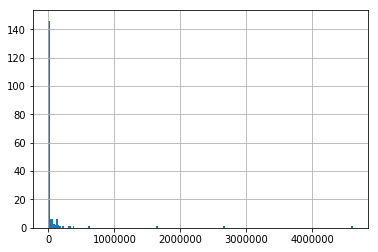

In [15]:
df2['src_tx'].hist(bins=200)

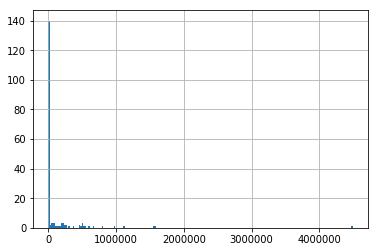

In [16]:
df2['dst_tx'].hist(bins=200)

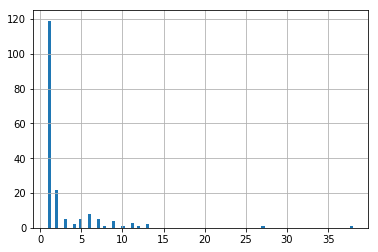

In [220]:
df2['num_conns'].hist(bins=100)

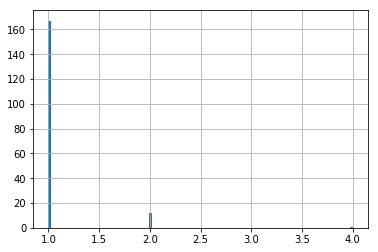

In [221]:
df2['num_dst_ports'].hist(bins=100)

## IQR based anomaly detection

- Arrange the data in increasing order.
- Calculate first(q1) and third quartile(q3)
- Find interquartile range (q3-q1)
- Find lower bound q1*1.5.
- Find upper bound q3*1.5.
- Anything that lies outside of lower and upper bound is an outlier.
- [ref](https://m.wikihow.com/Calculate-Outliers)

In [222]:
def find_iqr(ds):
    q1 = ds.quantile(0.25)
    q3 = ds.quantile(0.75)
    delta = (q3-q1)
    #print(delta)
    inner_fence = (q1 - delta*1.5, q3 + delta*1.5)
    outer_fence = (q1 - delta*3, q3 + delta*3)
    return outer_fence

In [223]:
find_iqr(df2['src_tx'])

(-28725.75, 39043.0)

In [248]:
OUTLIER_FEATURES = ['num_dst_ports', 'num_conns',]# 'dst_tx', 'src_tx']
def outlier_detection(df2):
    df_list = []
    for feature in OUTLIER_FEATURES:
        l,u = find_iqr(df2[feature])
        df3 = df2[ (df2[feature]<l) | (df2[feature]>u) ][feature]
        #print(df3)
        if len(df_list)==0:
            df_list = df3
        else:
            df_list = df_list.append(df3)
    df_list = df_list.reset_index()
    df_list[0]=0
    df_list = df_list.drop_duplicates()
    src_list = list( df_list['src_ip'] )
    dst_list = list( df_list['dst_ip'] )
    return zip(src_list, dst_list)

In [250]:
for sip,dip in outlier_detection(df2):
    print(sip, dip)

10.2.20.8 10.12.21.2
10.2.20.8 10.12.21.3
10.2.20.8 10.12.231.2
10.2.20.8 10.12.231.3
10.2.20.8 10.12.68.6
10.2.20.8 10.12.68.7
10.2.38.2 199.91.71.85
10.2.38.2 199.91.71.86
10.2.38.2 199.91.71.89
192.168.100.188 10.1.254.121
192.168.100.195 199.91.71.89
192.168.100.254 151.237.238.125
192.168.100.70 199.91.71.89
10.2.1.20 10.12.0.31
10.2.1.39 74.201.65.31
10.2.20.1 10.12.0.31
10.2.20.1 10.12.87.1
10.2.20.2 10.12.0.31
10.2.20.3 10.12.0.31
10.2.20.4 10.12.0.31
10.2.20.5 10.12.0.31
10.2.20.6 10.12.0.31
10.2.20.7 10.12.0.31
10.2.20.8 10.12.40.1
10.2.20.8 10.12.42.1
10.2.20.8 10.12.84.1
10.2.254.49 10.12.0.21
10.2.254.49 10.12.84.1
192.168.100.254 4.2.2.2
192.168.100.254 8.8.4.4
192.168.100.254 8.8.8.8
192.168.100.96 72.21.91.17
192.168.111.66 10.12.87.1


In [228]:
df_list = []
for feature in OUTLIER_FEATURES:
    l,u = find_iqr(df2[feature])
    df3 = df2[ (df2[feature]<l) | (df2[feature]>u) ][feature]
    #print(df3)
    if len(df_list)==0:
        df_list = df3
    else:
        df_list = df_list.append(df3)
df_list = df_list.reset_index()
df_list[0]=0
df_list.drop_duplicates()

,src_ip,dst_ip
0,10.2.20.8,10.12.21.2
1,10.2.20.8,10.12.21.3
2,10.2.20.8,10.12.231.2
3,10.2.20.8,10.12.231.3
4,10.2.20.8,10.12.68.6
5,10.2.20.8,10.12.68.7
6,10.2.38.2,199.91.71.85
7,10.2.38.2,199.91.71.86
8,10.2.38.2,199.91.71.89
9,192.168.100.188,10.1.254.121


In [198]:
#df_list.drop_duplicates()

,src_ip,dst_ip,0
0,10.2.20.8,10.2.20.8,0
1,192.168.100.254,192.168.100.254,0
3,10.2.254.49,10.2.254.49,0
5,192.168.100.96,192.168.100.96,0


In [206]:
df2

,,src_tx,dst_tx,num_conns,num_dst_ports,dst_ports_open
src_ip,dst_ip,,,,,
0.0.0.0,0.0.0.0,3470,0,1,1,[67]
10.1.1.12,10.1.1.12,2160,0,1,1,[3052]
10.12.24.4,10.12.24.4,318,318,1,1,[47205]
10.2.1.20,10.2.1.20,95033,408279,10,2,"[80, 1194]"
10.2.1.39,10.2.1.39,145653,62238,13,3,"[443, 161, 53]"
10.2.20.1,10.2.20.1,74760,1574425,18,3,"[80, 1194, 8125]"
10.2.20.2,10.2.20.2,324645,469705,7,2,"[80, 1194]"
10.2.20.3,10.2.20.3,163813,2086475,13,2,"[80, 1194]"
10.2.20.4,10.2.20.4,2678613,101433,13,3,"[80, 8125, 1194]"


In [189]:
df_list.to_frame().reset_index()[0].drop_duplicates()

,src_ip,dst_ip,0
0,10.2.20.8,10.2.20.8,8
1,192.168.100.254,192.168.100.254,10
2,10.2.20.8,10.2.20.8,86
3,10.2.254.49,10.2.254.49,65
4,192.168.100.254,192.168.100.254,38
5,192.168.100.96,192.168.100.96,38


In [181]:
df_list

src_ip           dst_ip         
10.2.20.8        10.2.20.8           8
192.168.100.254  192.168.100.254    10
10.2.20.8        10.2.20.8          86
10.2.254.49      10.2.254.49        65
192.168.100.254  192.168.100.254    38
192.168.100.96   192.168.100.96     38
dtype: int64